In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler
from keras.backend.tensorflow_backend import set_session
import math
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

IMG_SIZE=64

Using TensorFlow backend.


In [2]:
channels = 3
IMG_SIZE = 64
DATADIR = "/home/mtech/2020/satyaki_ghosh/datasets/VISION"
CATEGORIES = [
    "D01_Samsung_GalaxyS3Mini",
    "D02_Apple_iPhone4s",
    "D03_Huawei_P9",
    "D04_LG_D290",
    "D05_Apple_iPhone5c"]
patches_per_photo = 100
img_per_model = 150
num_classes = 5 


batch_size = 32
epochs = 80
image_dim = (IMG_SIZE, IMG_SIZE, 3)


# create generator
datagen = ImageDataGenerator(
                # featurewise_center=True,
                samplewise_center=True,
                rescale=0.0125
            )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('./data/train/', class_mode='categorical', batch_size=25000, target_size=(IMG_SIZE, IMG_SIZE))
val_it = datagen.flow_from_directory('./data/val/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('./data/test/', class_mode='categorical', batch_size=32, target_size=(IMG_SIZE, IMG_SIZE))
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print(batchy.shape)

Found 52500 images belonging to 5 classes.
Found 11000 images belonging to 5 classes.
Found 11000 images belonging to 5 classes.
Batch shape=(25000, 64, 64, 3), min=-2.808, max=3.032
(25000, 5)


In [8]:
np.mean(batchX, axis=0).shape

(64, 64, 3)

In [ ]:
model = Sequential()
# layer 1 
model.add(Conv2D(32, (4, 4), padding='valid', strides=(1,1), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 2
model.add(Conv2D(48, (5, 5), padding='valid', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 3
model.add(Conv2D(64, (5, 5), padding='same', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 4
model.add(Conv2D(128, (5, 5), strides=(1,1)))
# layer 5

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate = 0.015, momentum = 0.9, decay = 0.0075)
model.compile(loss = "categorical_crossentropy", optimizer = opt , metrics = [tf.keras.metrics.CategoricalAccuracy()])                

model.summary()
model.load_weights('./training_1/cp_0080.ckpt')

### TESTING


In [2]:
hist = np.load('train_history_dict_patchsize64.npy', allow_pickle=True).item()
hist.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

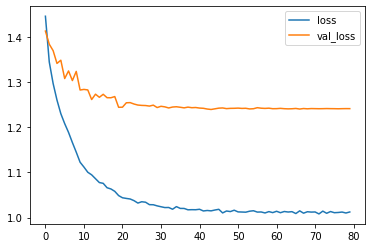

In [5]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()

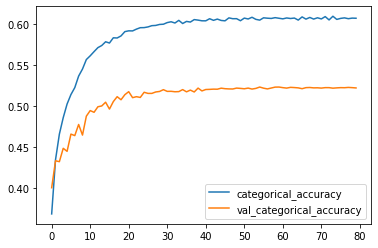

In [7]:
plt.plot(hist['categorical_accuracy'], label='categorical_accuracy')
plt.plot(hist['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()

In [10]:
Y_pred_label_distrib = np.load('Y_pred_label_distrib_patchsize64.npy', allow_pickle=True)
print(Y_pred_label_distrib)

[[   0    1    2    3    4]
 [2243 1728 2017 2434 2578]]


In [11]:
confusion_matrix = np.load('confusion_matrix_patchsize64.npy', allow_pickle=True)
print(confusion_matrix)

[[426 324 444 476 530]
 [448 352 394 481 525]
 [432 322 390 531 525]
 [475 346 392 464 523]
 [462 384 397 482 475]]


In [ ]:
def evaluate_model():
    loss, acc  = model.evaluate_generator(test_it)
    # print("Accuracy: {:5.2f}%".format(100 * acc))


    # Checking label distributions
    Y_pred = model.predict_generator(test_it)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_test = test_it.classes
    print(f'Y_train label distrib: {np.unique(Y, return_counts=True)}')
    print(f'Y_test label distrib: {np.unique(Y_test, return_counts=True)}')
    y_pred_distrib = np.unique(Y_pred, return_counts=True)
    print(f'Y_pred_label distrib: {y_pred_distrib}')
    print(f'Number of different predicted labels: {np.shape(np.unique(Y_pred, return_counts=True))}')


    # Confusion Matrix
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(f"Confusion matrix: \n{confusion_matrix(Y_test, Y_pred)}")
    print(f"Classification Report:\n {classification_report(Y_test, Y_pred)}")

    
# try getting GPU until it is done
ran = False
while ran == False:
    try:
        evaluate_model()
        ran = True
    except:
        print("")

### SVM

In [3]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,LearningRateScheduler
from keras.backend.tensorflow_backend import set_session
import math
from keras.preprocessing.image import ImageDataGenerator



gpu_options = tf.compat.v1.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.8)
config = tf.compat.v1.ConfigProto(
    device_count={'GPU': 10, 'CPU': 10},
    gpu_options=gpu_options,
    intra_op_parallelism_threads=32,
    inter_op_parallelism_threads=32,
    )
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)



channels = 3
IMG_SIZE = 64
DATADIR = "/home/mtech/2020/satyaki_ghosh/datasets/VISION"
CATEGORIES = [
    "D01_Samsung_GalaxyS3Mini",
    "D02_Apple_iPhone4s",
    "D03_Huawei_P9",
    "D04_LG_D290",
    "D05_Apple_iPhone5c"]
patches_per_photo = 100
img_per_model = 150
num_classes = 5
batch_size = 128
epochs = 80
image_dim = (IMG_SIZE, IMG_SIZE, 3)



# define the model
model = Sequential()
# layer 1 
model.add(Conv2D(32, (4, 4), padding='valid', strides=(1,1), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 2
model.add(Conv2D(48, (5, 5), padding='valid', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 3
model.add(Conv2D(64, (5, 5), padding='same', strides=(1,1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 4
model.add(Conv2D(128, (5, 5), strides=(1,1)))
model.add(Flatten())
# layer 5
model.add(Dense(128, activation='relu'))
# layer 6
model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate = 0.015, momentum = 0.9, decay = 0.0075)
model.compile(loss = "categorical_crossentropy", optimizer = opt , metrics = [tf.keras.metrics.CategoricalAccuracy()])                
model.summary()

model.load_weights('./training_1/cp_0080.ckpt')


# define the encoder
encoder = Sequential()
# layer 1 
encoder.add(Conv2D(32, (4, 4), padding='valid', strides=(1,1), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
encoder.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 2
encoder.add(Conv2D(48, (5, 5), padding='valid', strides=(1,1)))
encoder.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 3
encoder.add(Conv2D(64, (5, 5), padding='same', strides=(1,1)))
encoder.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 4
encoder.add(Conv2D(128, (5, 5), strides=(1,1)))
encoder.add(Flatten())
# layer 5
encoder.add(Dense(128, activation='relu'))
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        76864     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         2

In [4]:
#set weights of the first layer
for i in range(len(encoder.layers)):
    encoder.layers[i].set_weights(model.layers[i].get_weights())

#compile it after setting the weights
#new_model.compile(optimizer='adam', loss='categorical_crossentropy')
opt = tf.keras.optimizers.SGD(learning_rate = 0.015, momentum = 0.9, decay = 0.0075)
encoder.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = [tf.keras.metrics.CategoricalAccuracy()])    

In [5]:
# try getting GPU until it is done
ran = False
while ran == False:
    try:
        output = encoder.predict_generator(test_it)
        ran = True
    except:
        pass

In [6]:
print(output.shape)

(11000, 128)


In [12]:
Y_test = test_it.classes
print(Y_test.shape)
print(np.unique(Y_test, return_counts=True))

(11000,)
(array([0, 1, 2, 3, 4], dtype=int32), array([2200, 2200, 2200, 2200, 2200]))
